# Phase1_Project

> #### Objective : To provide to Microsoft Studio information on the kinds of movies that are doing well at the box office

In [69]:
# Importing relevant libraries

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
conn = sqlite3.connect('im.db')

In [70]:
# initial look at the different tables
# converting all the tables into a df using the dataframe constructor 

movie_basics = pd.DataFrame(pd.read_sql('SELECT * FROM movie_basics',conn))
movie_basics.head()


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [71]:
movie_ratings = pd.DataFrame(pd.read_sql('SELECT * FROM movie_ratings',conn))
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [72]:
movie_akas = pd.DataFrame(pd.read_sql('SELECT * FROM movie_akas',conn))
movie_akas.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [73]:
# Getting an idea of the size of the tables

print('Shape of movie_basics table :',movie_basics.shape)
print('Shape of movie_ratings table :',movie_ratings.shape)
print('Shape of movie_akas table : ',movie_akas.shape)


Shape of movie_basics table : (146144, 6)
Shape of movie_ratings table : (73856, 3)
Shape of movie_akas table :  (331703, 8)


> **From the shapes of the tables, we can see that there is a** ***disparity in the amount of data between the tables.***
**Let's start by analyzing the movie_basics table**

In [74]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


>We can see that ***original_title, runtime_minutes and genres have missing values.***
 Getting an idea of the amount of missing data:

In [75]:
print('Number of rows missing in the original_title column :',len(movie_basics[movie_basics['original_title'].isna()]))
print('Number of rows missing in the runtime_miutes column :',len(movie_basics[movie_basics['runtime_minutes'].isna()]))
print('Number of rows missing in the genres column :',len(movie_basics[movie_basics['genres'].isna()]))


Number of rows missing in the original_title column : 21
Number of rows missing in the runtime_miutes column : 31739
Number of rows missing in the genres column : 5408


> ***Since the missing data in the 'original_title' is < 1%, we can delete those rows without suffering any consequences.***


In [76]:
# using .dropna to remove rows with NaN values in the 'original_title' columns

movie_basics.dropna(subset=['original_title'], inplace = True)

In [77]:
# check to the see the if the numbers have changed

movie_basics.info()

# can see the number of rows have reduced from 146144 to 146123

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146123 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146123 non-null  object 
 1   primary_title    146123 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146123 non-null  int64  
 4   runtime_minutes  114401 non-null  float64
 5   genres           140734 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 7.8+ MB


> ***Since we will not be examining the runtime_minutes for our analysis, we can remove the column from the dataset.***

In [78]:
movie_basics.drop('runtime_minutes', axis=1, inplace = True)
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146123 entries, 0 to 146143
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   movie_id        146123 non-null  object
 1   primary_title   146123 non-null  object
 2   original_title  146123 non-null  object
 3   start_year      146123 non-null  int64 
 4   genres          140734 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.7+ MB


> ***Examining the 'genres' column:***

In [79]:
movie_basics['genres'].value_counts()

Documentary                    32185
Drama                          21486
Comedy                          9177
Horror                          4372
Comedy,Drama                    3519
                               ...  
Horror,Musical,Thriller            1
Biography,Family,Fantasy           1
Music,Sci-Fi,Thriller              1
Drama,Mystery,Sport                1
Documentary,News,Reality-TV        1
Name: genres, Length: 1085, dtype: int64

In [80]:
#creating a new column that splits the genres

movie_basics["genres_split"] = movie_basics['genres'].str.split(",")
movie_basics.head()

,movie_id,primary_title,original_title,start_year,genres,genres_split
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama","[Action, Crime, Drama]"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,"Biography,Drama","[Biography, Drama]"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,Drama,[Drama]
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,"Comedy,Drama","[Comedy, Drama]"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,"Comedy,Drama,Fantasy","[Comedy, Drama, Fantasy]"


In [81]:
# with the exolode method you have to create a new df for it to take effect

movie_basics2 = movie_basics.explode("genres_split")
movie_basics2.head()

,movie_id,primary_title,original_title,start_year,genres,genres_split
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama",Action
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama",Crime
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama",Drama
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,"Biography,Drama",Biography
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,"Biography,Drama",Drama


> ***We can see that the values are varied(1085). Also, some movies are classified under 2-3 genres making it difficult for us to predict what the missing genres might be. 
Since the amount of missing data for the genres is also quite large i.e 5389 rows, filling in missing values with guesswork can skew the analysis in any number of ways. So the best way would be to just classify the data as 'missing'***


In [82]:
movie_basics['genres'].fillna('missing',inplace = True)

In [83]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146123 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   movie_id        146123 non-null  object
 1   primary_title   146123 non-null  object
 2   original_title  146123 non-null  object
 3   start_year      146123 non-null  int64 
 4   genres          146123 non-null  object
 5   genres_split    140734 non-null  object
dtypes: int64(1), object(5)
memory usage: 7.8+ MB


> ***Since the 'movie_id' is the primary key in the movie_basics table and the foreign key in the movie_ratings and movie_akas table, let's check to see if there are any duplicate values in the movie_basics table.***

In [84]:
movie_basics.duplicated(subset = ['movie_id']).value_counts()

False    146123
dtype: int64

In [85]:
movie_basics.duplicated(subset = ['primary_title']).value_counts()

False    136056
True      10067
dtype: int64

>***We have now cleaned up the movie_basics table by:***
- ***Removing null values from the original_title columns***
- ***Removing the runtime_minutes column entirely***
- ***Classifying null values in the 'genres' column as 'missing***

> ***Next up is the movie_ratings table:***

In [86]:
# Getting info about the movie_ratings table
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


> ***From the above we can see that there no null values.
But there is a difference in the number of rows: The movie_ratings table has 73,856 rows while the movie_basics has 146,123 rows indicating that not all movies listed in the movie_basics table are listed in the ratings table as well.***

In [87]:
# Checking to see if there are any missing values
movie_ratings.isna().any()

# from the results, we can see that movie_ratings table has no missing values

movie_id         False
averagerating    False
numvotes         False
dtype: bool

In [88]:
# creating a new datafrome by merging the movie_basics and the movie_ratings table using a left join
# this is will result in movies without ratings and numvotes due to the disparity between the two tables

df = movie_basics.merge(movie_ratings, how = 'left', on = 'movie_id',)
df.head()

,movie_id,primary_title,original_title,start_year,genres,genres_split,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama","[Action, Crime, Drama]",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,"Biography,Drama","[Biography, Drama]",7.2,43.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,Drama,[Drama],6.9,4517.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,"Comedy,Drama","[Comedy, Drama]",6.1,13.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,"Comedy,Drama,Fantasy","[Comedy, Drama, Fantasy]",6.5,119.0


> ***Since ratings are not a focus of the analysis, let's ignore the movies with missing ratings. The ratings are also an avergae value derived from the numvotes and since the numvotes are not consistent, one cannot conclude that the ratings are a true reflection of audience aprrovals/disapprovals.***

>***Since the ultimate goal is to make money, the info from the movie_gross is table is paramount for the analysis.***

In [89]:
# converting the movie_gross table into a dataframe

movie_gross = pd.DataFrame(pd.read_csv('bom.movie_gross.csv'))
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


>***Let's combine movie_basics and the movie_gross tables to get information on how much money each movie has made***

In [91]:
# using the merge method

movie_gross_df = df.merge(movie_gross, how = 'left', left_on = 'primary_title', right_on = 'title')
movie_gross_df.head()

,movie_id,primary_title,original_title,start_year,genres,genres_split,averagerating,numvotes,title,studio,domestic_gross,foreign_gross,year
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama","[Action, Crime, Drama]",7.0,77.0,NaN,NaN,NaN,NaN,NaN
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,"Biography,Drama","[Biography, Drama]",7.2,43.0,NaN,NaN,NaN,NaN,NaN
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,Drama,[Drama],6.9,4517.0,NaN,NaN,NaN,NaN,NaN
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,"Comedy,Drama","[Comedy, Drama]",6.1,13.0,NaN,NaN,NaN,NaN,NaN
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,"Comedy,Drama,Fantasy","[Comedy, Drama, Fantasy]",6.5,119.0,NaN,NaN,NaN,NaN,NaN


In [68]:
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146125 entries, 0 to 146124
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   movie_id        146125 non-null  object 
 1   primary_title   146125 non-null  object 
 2   original_title  146125 non-null  object 
 3   start_year      146125 non-null  int64  
 4   genres          146125 non-null  object 
 5   genres_split    140736 non-null  object 
 6   averagerating   73858 non-null   float64
 7   numvotes        73858 non-null   float64
 8   title           3366 non-null    object 
 9   studio          3363 non-null    object 
 10  domestic_gross  3342 non-null    float64
 11  foreign_gross   2043 non-null    float64
 12  year            3366 non-null    float64
dtypes: float64(5), int64(1), object(7)
memory usage: 15.6+ MB


> ***To look at total_gross, need to sum domestic_gross and foreign_gross. From the above we can see that foreign_gross is listed as an object data type. Need to convert this to float64 to be able to compute the sum***

In [92]:
# removing the ',' from the string
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].str.replace(',','') 

# converting 'foreign_gross' to float datatype
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].astype('float64')


In [93]:
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146125 entries, 0 to 146124
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   movie_id        146125 non-null  object 
 1   primary_title   146125 non-null  object 
 2   original_title  146125 non-null  object 
 3   start_year      146125 non-null  int64  
 4   genres          146125 non-null  object 
 5   genres_split    140736 non-null  object 
 6   averagerating   73858 non-null   float64
 7   numvotes        73858 non-null   float64
 8   title           3366 non-null    object 
 9   studio          3363 non-null    object 
 10  domestic_gross  3342 non-null    float64
 11  foreign_gross   2043 non-null    float64
 12  year            3366 non-null    float64
dtypes: float64(5), int64(1), object(7)
memory usage: 15.6+ MB


> ***The aim of the analysis is to rank movies based on total_gross and examine them for further details, since the aim of any business is to be profitable. While we have info for 146,125 movie titles, there are only gross amounts for 3366 movies. So, let's work with what we have***

> ***That means, we will have to whittle down the movie_basics dataset to match the info that's available in the movie_gross dataset.
Having (146,125 - 3366) rows of data without the total_gross info makes for a lot of redundant data. So, let's condense the dataset to data that we're going to use.***

> ***Let's look at the two tables again:***

In [94]:
movie_basics.head()

,movie_id,primary_title,original_title,start_year,genres,genres_split
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama","[Action, Crime, Drama]"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,"Biography,Drama","[Biography, Drama]"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,Drama,[Drama]
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,"Comedy,Drama","[Comedy, Drama]"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,"Comedy,Drama,Fantasy","[Comedy, Drama, Fantasy]"


In [95]:
movie_basics.loc[movie_basics['primary_title'] == 'On the Road']

,movie_id,primary_title,original_title,start_year,genres,genres_split
48,tt0337692,On the Road,On the Road,2012,"Adventure,Drama,Romance","[Adventure, Drama, Romance]"
39490,tt2404548,On the Road,On the Road,2011,Drama,[Drama]
68078,tt3872966,On the Road,On the Road,2013,Documentary,[Documentary]
76007,tt4339118,On the Road,On the Road,2014,Drama,[Drama]
93026,tt5389486,On the Road,On the Road,2015,Documentary,[Documentary]
96791,tt5647250,On the Road,On the Road,2016,Drama,[Drama]


In [96]:
movie_gross.rename(columns = {'title' : 'primary_title'}, inplace = True)
movie_gross.head()


,primary_title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


> ***We can do an 'inner' merge based on 'primary_title' from the movie_basics table and 'title' from the movie_gross table*** 

In [97]:
new_df = movie_basics.merge(movie_gross, how = 'inner', on = 'primary_title')
new_df.head()

,movie_id,primary_title,original_title,start_year,genres,genres_split,studio,domestic_gross,foreign_gross,year
0,tt0315642,Wazir,Wazir,2016,"Action,Crime,Drama","[Action, Crime, Drama]",Relbig.,1100000.0,NaN,2016
1,tt0337692,On the Road,On the Road,2012,"Adventure,Drama,Romance","[Adventure, Drama, Romance]",IFC,744000.0,8000000,2012
2,tt2404548,On the Road,On the Road,2011,Drama,[Drama],IFC,744000.0,8000000,2012
3,tt3872966,On the Road,On the Road,2013,Documentary,[Documentary],IFC,744000.0,8000000,2012
4,tt4339118,On the Road,On the Road,2014,Drama,[Drama],IFC,744000.0,8000000,2012


In [100]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   genres_split    3326 non-null   object 
 6   studio          3363 non-null   object 
 7   domestic_gross  3342 non-null   float64
 8   foreign_gross   2043 non-null   float64
 9   year            3366 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 289.3+ KB


In [99]:
# removing the ',' from the string
new_df['foreign_gross'] = new_df['foreign_gross'].str.replace(',','') 

# converting 'foreign_gross' to float datatype
new_df['foreign_gross'] = new_df['foreign_gross'].astype('float64')

In [101]:
new_df.duplicated(subset = ['primary_title']).value_counts()

False    2605
True      761
dtype: int64

> ***We can also see that there are some missing values in the domestic and foreign gross columns. Let's examine them:***

In [102]:
# going back to the movie_gross table

print(new_df['domestic_gross'].isna().value_counts())
print(new_df['foreign_gross'].isna().value_counts())

False    3342
True       24
Name: domestic_gross, dtype: int64
False    2043
True     1323
Name: foreign_gross, dtype: int64


Getting some stats of the domestic_gross column to see if we can impute values

In [103]:
# we can create a function to compute the stats of any a pandas series
# we can just have the pass the series name as an argument into the function

def stats(column):
    
    mean_value = round(column.mean())
    median_value = round(column.median())
    std_dev = round(column.std())
    
    return mean_value, median_value,std_dev       

In [104]:
stat_values = stats(new_df['domestic_gross'])
stat_values

(29865597.0, 1950000.0, 65323288.0)

Let's impute the median value for the missing data in the domestic_gross column and re-compute the stats to see if there is 
any discernible change

In [105]:
# Imputing the median value
new_df['domestic_gross'] = new_df['domestic_gross'].fillna(stat_values[1])

In [106]:
# checking to see if any missing data 
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   genres_split    3326 non-null   object 
 6   studio          3363 non-null   object 
 7   domestic_gross  3366 non-null   float64
 8   foreign_gross   2043 non-null   float64
 9   year            3366 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 289.3+ KB


We can see that the domestic_gross has no more null values

In [107]:
# re-computing the stats
new_stat_values = stats(new_df['domestic_gross'])
new_stat_values

(29666555.0, 1950000.0, 65132297.0)

In [108]:
# Calculating percentage change:

mean_change = ((new_stat_values[0]-stat_values[0])/stat_values[0]) * 100
median_change = ((new_stat_values[1]-stat_values[1])/stat_values[1]) * 100
std_dev_change = ((new_stat_values[2]-stat_values[2])/stat_values[2]) * 100

print(mean_change, "", median_change, "", std_dev_change)

-0.6664591369126155  0.0  -0.2923781178926572


We can see that there is less than 1% change if we impute the median value. So, let's keep this

Let's examine the foreign gross column

In [109]:
new_df['foreign_gross'].isna().value_counts()

False    2043
True     1323
Name: foreign_gross, dtype: int64

We can that there are 1323 empty values. Let's compute the stats again to get an idea of what we can impute.
First, we need to convert it to the float data type

Apparently, some of the values in the foreign_gross column have special characters in them: like in the above, there is a comma in the string. So, we have to remove all special characters in the foreign_gross column for the datatype conversion to work.

In [110]:
# removing the ',' from the string
new_df['foreign_gross'] = new_df['foreign_gross'].str.replace(',','') 

# converting 'foreign_gross' to float datatype
new_df['foreign_gross'] = new_df['foreign_gross'].astype('float64')


AttributeError: Can only use .str accessor with string values!

In [111]:
# compute the stats 
fd_stats = stats(new_df['foreign_gross'])
fd_stats

(74551466.0, 19600000.0, 134783459.0)

Note about the data : None of the stats can be considered to be accurate due to large volume of missing data ( ~ 50%). But, let's try this anyway. We can exclude the foreign_gross data if we choose to do so later.

In [112]:
#imputing the median value
new_df['foreign_gross'] = new_df['foreign_gross'].fillna(fd_stats[1])

In [113]:
# check the table
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   genres_split    3326 non-null   object 
 6   studio          3363 non-null   object 
 7   domestic_gross  3366 non-null   float64
 8   foreign_gross   3366 non-null   float64
 9   year            3366 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 289.3+ KB


In [114]:
#re-compute stats
fd_new_stats = stats(new_df['foreign_gross'])
fd_new_stats

(52952895.0, 19600000.0, 108373000.0)

Let's add a new column to see how much each movie grossed totally: domestic + overseas

In [115]:
new_df['total_gross'] = new_df['domestic_gross'] + new_df['foreign_gross']

In [116]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   genres_split    3326 non-null   object 
 6   studio          3363 non-null   object 
 7   domestic_gross  3366 non-null   float64
 8   foreign_gross   3366 non-null   float64
 9   year            3366 non-null   int64  
 10  total_gross     3366 non-null   float64
dtypes: float64(3), int64(2), object(6)
memory usage: 315.6+ KB


In [117]:
new_df.isna().any()

movie_id          False
primary_title     False
original_title    False
start_year        False
genres            False
genres_split       True
studio             True
domestic_gross    False
foreign_gross     False
year              False
total_gross       False
dtype: bool

Let's plot to see how much genres grossed

In [118]:
new_df.head()

,movie_id,primary_title,original_title,start_year,genres,genres_split,studio,domestic_gross,foreign_gross,year,total_gross
0,tt0315642,Wazir,Wazir,2016,"Action,Crime,Drama","[Action, Crime, Drama]",Relbig.,1100000.0,19600000.0,2016,20700000.0
1,tt0337692,On the Road,On the Road,2012,"Adventure,Drama,Romance","[Adventure, Drama, Romance]",IFC,744000.0,8000000.0,2012,8744000.0
2,tt2404548,On the Road,On the Road,2011,Drama,[Drama],IFC,744000.0,8000000.0,2012,8744000.0
3,tt3872966,On the Road,On the Road,2013,Documentary,[Documentary],IFC,744000.0,8000000.0,2012,8744000.0
4,tt4339118,On the Road,On the Road,2014,Drama,[Drama],IFC,744000.0,8000000.0,2012,8744000.0


In [119]:
new_df.duplicated(subset = ['primary_title']).value_counts()

False    2605
True      761
dtype: int64

In [123]:
sums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 2010 to 2018
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   start_year      9 non-null      int64  
 1   domestic_gross  9 non-null      float64
 2   foreign_gross   9 non-null      float64
 3   total_gross     9 non-null      float64
dtypes: float64(3), int64(1)
memory usage: 360.0 bytes


In [128]:
sums = new_df.groupby('year').sum()


In [129]:
sums.head()

,start_year,domestic_gross,foreign_gross,total_gross
year,,,,
2010,545142,1.014042e+10,1.334862e+10,2.348904e+10
2011,786564,1.022422e+10,1.764970e+10,2.787392e+10
2012,825051,1.008024e+10,1.726660e+10,2.734684e+10
2013,704545,1.138482e+10,2.108349e+10,3.246831e+10
2014,767243,1.062362e+10,2.025305e+10,3.087668e+10


In [131]:
sums.reset_index(inplace = True)

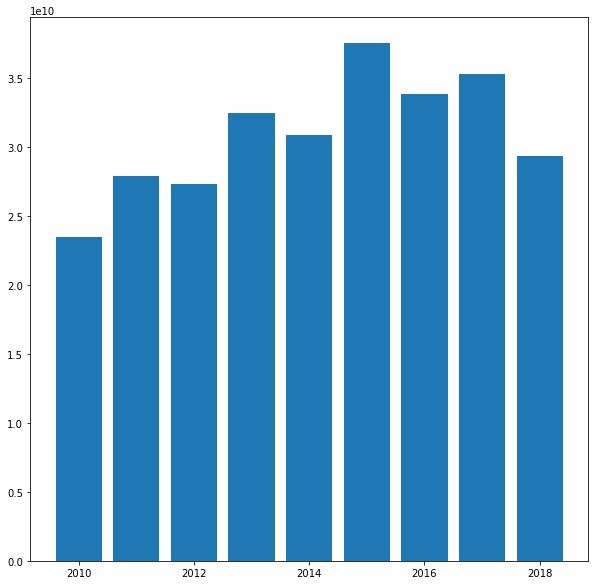

In [141]:
fig, ax = plt.subplots(figsize = (10,10))

ax.bar(x = sums['year'], height = sums['total_gross'])
plt.show()

In [143]:
sums2 = sums.sum()


ValueError: key of type tuple not found and not a MultiIndex

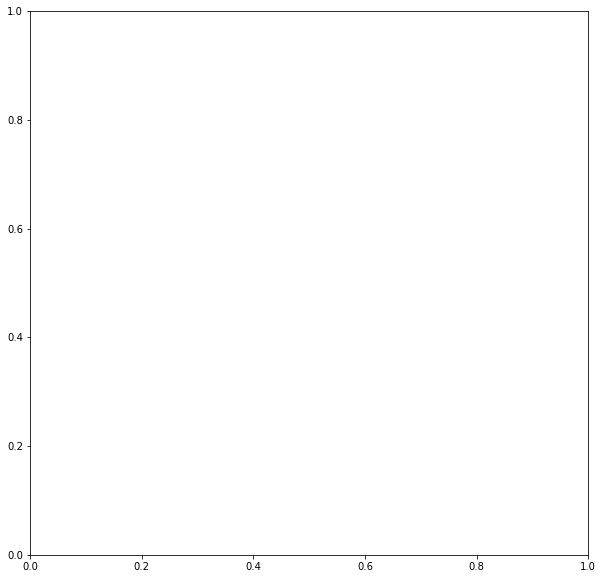

In [151]:
fig, ax = plt.subplots(figsize = (10,10))

ax.bar(x = sums2['domestic_gross','foreign_gross'], y = sums2['total_gross'])
plt.show()